In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_are
import math
%matplotlib inline
# %matplotlib notebook

# the library requires "optional" dependencies not available in pip for almost all basic functions, 
# but plotting for zonotopes with a small amount of generators works fine.
# Plotting Zonotopes is the only intended use in the tutorial!
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.488.5151&rep=rep1&type=pdf
!pip install pypolycontain
import pypolycontain as pp 

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, Polygon, MultiPoint
from matplotlib.patches import Ellipse

# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\kupuk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# (E level) Reachability and object detection using zonotopes

In this part of the tutorial, we will apply the findings of the previous tutorial to a collision-avoidance scenario! Given that we can now compute the permissible space of an autonomous system of the form 

$ \dot{x}(t) = A x(t) + d(t) $

were $d(t)$ is a bounded disturbance (in the previous tutorial $u(t)$), we can check the check the collision of two systems when propagated through time. 
As such, we will subject a nominally stable object and a controllable 'robot' of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

to a zonotope collision check. We will use LQR to stabilize the system subjected to our preferences!

# The Object
We consider a moving obstacle which might cause issues for the robot's planned trajectory. We consider the obstacle as a first order integrator system with an uncertain initial position, $\mathcal{N}(\mu,\sigma^2)$. What we do know is that the $x$ and $y$ coordinate of the system are normally distributed according to

$x_0 \sim \mathcal{N}(2.5,0.05)$

$y_0 \sim \mathcal{N}(-3.5,0.055)$

We will first prescribe a zonotope with 2 generators that most closely describes this multivariate Gaussian distribution in the 2 dimensional plane at a confidence interval of 90%.

The true initial position distribution takes a specific shape (ellipse!). We then wish to find the generators that generate a rectangle zonotope that most closely captures this distribution at 90% confidence!

Note that we wish to find the $z_p$ value that scales the standard deviation and captures the probability of laying inside a specific range of real numbers, centered at the mean $\mu$ according to

$ Pr[x \in [\mu-z_p \sigma, \mu+z_p \sigma]] = p$

Although **you should compute this $z_p$ value yourself**, to help you out, the value should be 1.64485.

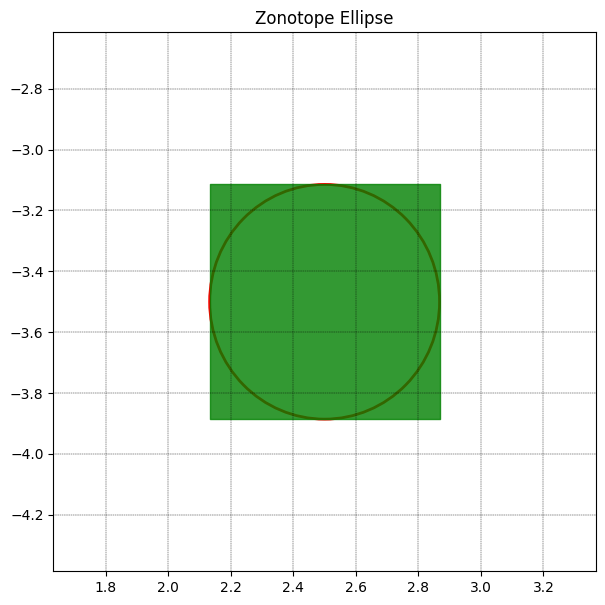

In [14]:
Sigma = np.sqrt(np.array([0.05, 0.055]))
Mu = np.array([2.5, -3.5])

# general equation of an ellipse: (x/a)^2 + (y/b)^2 = s

# The probability of, from the positive domain w.r.t. mu,
# being in the 90 percent confidence interval
# https://en.wikipedia.org/wiki/Normal_distribution
z = 1.64485

# The major and minor axes of the ellipse
# x and y can vary from 2.5 +- z*sigma.
# The major axis will be y (since it is larger)

semi_major_axis = z * Sigma[1]
semi_minor_axis = z * Sigma[0]

# find an enclosing 2D zonotope
# https://mediatum.ub.tum.de/doc/1554653/365916.pdf
c0 = Mu
g0 = np.array([[semi_minor_axis, 0], [0, semi_major_axis]])
z0 = pp.zonotope(x=c0, G=g0)

# Plotting of the zonotope and the ellipse
fig, ax = plt.subplots()
try:
    ellipse = Ellipse(
        xy=Mu,
        width=2 * semi_minor_axis,
        height=2 * semi_major_axis,
        edgecolor="r",
        fc="None",
        lw=2,
    )
    
    ax.add_patch(ellipse)
    pp.visualize(
        [z0], title="Zonotope Ellipse", fig=fig, ax=ax
    )  # pp.visualize() does all the hard work for us
except:
    pass
fig.set_size_inches(7, 7)

Now, let's take a step back and first generalize the results from the previous part into a function. Given some input data (see below), we want a function that returns the list of zonotopes. 

This mostly involves using the code from the previous part and turning it into a function.

In [15]:
def compute_zonotopes_loop(q_c, q_g, e_ra, alpha_beta_box_g, zt_init, n, color, simplify):
    """
    Function to compute zonotopes for a given number of iterations.
    input : q_c = center of zonotope
            q_g = generators of zonotope
            e_ra = matrix
            alpha_beta_box_g = matrix
            zt_init = initial zonotope
            n = number of iterations
            color = color of the zonotope
            simplify = boolean to simplify the zonotope

    output : zonotopes_to_plot = array of zonotopes to plot
    """
    zonotopes_to_plot = []  # we will use this to store our results

    # loop to compute pi and qi from predecessors
    for i in range(1, n):
        pi_c = e_ra @ q_c[i - 1]
        pi_g = e_ra @ q_g[i - 1]
        qi_c = pi_c
        qi_g = np.hstack((pi_g, alpha_beta_box_g))

        q_c.append(qi_c)
        q_g.append(qi_g)

    if simplify:
        for i in range(0, n):
            qi_g_reduced = np.zeros((2, 2))
            for index, row in enumerate(q_g[i]):
                qi_g_reduced[index, index] = np.sum(np.abs(row))
            zonotopes_to_plot.append(pp.zonotope(x=q_c[i], G=qi_g_reduced, color=color))
    else:
        for i in range(0, n):
            zonotopes_to_plot.append(pp.zonotope(x=q_c[i], G=q_g[i]))
    zonotopes_to_plot.append(zt_init)
    return zonotopes_to_plot

In [16]:
def get_zonotopes(A, mu, c0, g0, t, r, color="g", simplify=False):

    # where
    # A: system matrix
    # mu: bounded disturbance
    # c0: initial condition
    # g0: initial generators
    # t: total simulation time
    # r: duration of time-step
    # color: the color of the zonotopes, helps distinguishing later on
    # simplify: do we lower the order of the zonotopes? (already with 2 generators so not always necessary)

    zt_init = pp.zonotope(x=c0, G=g0, color="r")  # initial zonotope

    n = int(t / r)  # amount of time steps

    # derived constants from pseudo code
    A_norm = np.linalg.norm(A, np.inf)
    e_ra = np.array(expm(r * A))

    sup_ig = max(
        np.linalg.norm(g, np.inf) for g in g0.T
    )  # iterate over columns, which are the generators of  the initial zonotope
    alpha = (np.exp(r * A_norm) - 1 - r * A_norm) * sup_ig
    beta = ((np.exp(r * A_norm) - 1) / A_norm) * mu

    beta_box_g = np.array([[beta, 0], [0, beta]]).reshape(2, 2)
    alpha_beta_box_g = np.array([[alpha + beta, 0], [0, alpha + beta]]).reshape(2, 2)

    # p0 computations - center vector
    p0_c = (c0 + e_ra @ c0) / 2

    # p0 computations - generators
    p0_g = np.zeros((2, 2 * g0.shape[1] + 1))

    for i in range(g0.shape[1]):
        g = g0[:, i]
        p0_g[:, i] = (g + e_ra @ g) / 2
        p0_g[:, i + 2] = (g - e_ra @ g) / 2
    p0_g[:, -1] = (c0 - e_ra @ c0) / 2

    q0_c = p0_c
    q0_g = np.hstack(
        (p0_g, alpha_beta_box_g)
    )  # Combine P0 generators with alpha+beta generators

    # lists to store the q generators and centers
    q_g = []
    q_c = []
    # q0 computations
    q_c.append(q0_c)
    q_g.append(q0_g)

    zts = compute_zonotopes_loop(q_c, q_g, e_ra, alpha_beta_box_g, zt_init, n, color, simplify)

    return zts  # return the zonotopes

Now let's call the function for the object and visualize our nominally stable trajectory! 

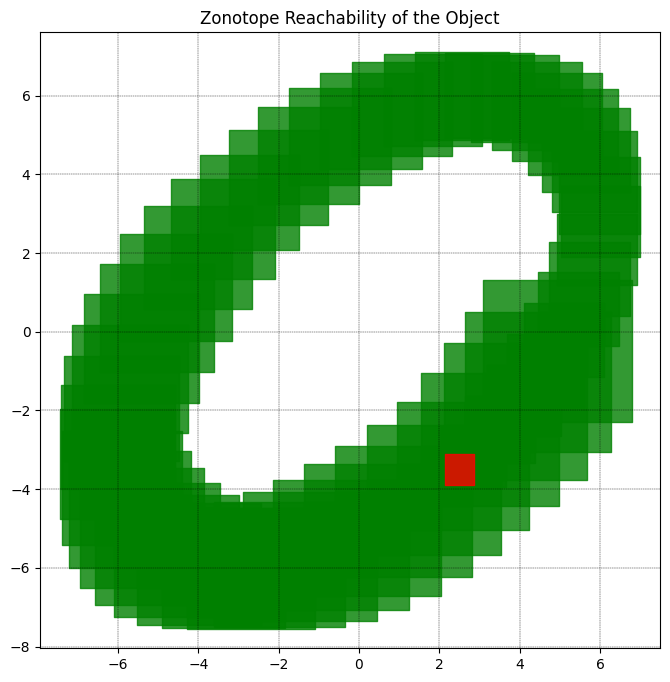

In [17]:
# duration of simulation
sim_duration = 4
r = 0.075
Ac = np.array([[1, -2], [2, -1]])
# A_test = np.array([[-1., -4.], [4., -1.]])
mu = 0.02  # note that this is the disturbance, not the mean

c0 = c0
g0 = g0
c0_test = np.array([1, 0])  # center of the initial zonotope
g0_test = np.array([[0.1, 0, 0.05], [0, 0.1, 0.05]])  # generators of the initial zonotope

zts_obj = get_zonotopes(Ac, mu, c0, g0, sim_duration, r, simplify=True)
fig, ax = plt.subplots()
try:
    pp.visualize(zts_obj, title="Zonotope Reachability of the Object", fig=fig, ax=ax)
except:
    pass
plt.show()

# The Robot!
Our robot model is given by a similar 2D single-integrator system. As mentioned, this is of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

$ \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} -1 & 1 \\ -1 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} u_x \\ u_y \end{bmatrix} + d(t)$

which can be written in the desired autonomous form when a state-feedback control policy is applied. Our state-feedback will be obtained via [LQR](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) which gives us an appropriate state-feedback controller given certain weights on the state deviation and the control input.

For our purposes, we wish to penalize both state-deviation and control input equally in the vertical and horizontal plane. In all situations, we do not penalize any cross-terms. For the state-deviation, we consider a weight of $50$ and for the control input a weight of $5$ respectively.

Below, implement the system and weight matrices and obtain the LQR closed-loop stabilized system by solving the continuous-time algebraic Ricatti equation using the `scipy` package. We then plot the zonotopes of the object and the robot in a single plot (use the color argument in your `get_zonotopes()` function!)

## Some intuition
While "solving the ARE" seems very arbitrary, the intuition is quite straightforward. Note that we have the optimization problem

$ \min(\int_0^{\infty} (x(t)^T Q x(t) + u(t)^T R u(t))dt )$

s.t. $\dot{x}(t) = Ax(t) + Bu(t)$

It turns out that it is easy to solve this problem as we have a quadratic cost and a linear system! The relevant steps are that we first pick a positive definite symmetric matrix $P = P^T$ and add two terms to the cost that cancel eachother out

$ x_0^T P x_0 - x_0^T P x_0 + \int_0^{\infty} (x(t)^T Q x(t) + u(t)^T R u(t))dt$

for which we can take $-x_0^T P x_0$ into the integral sign. Notice that $\frac{d}{dt}(x^T P x) = \dot{x}^T P x + x^T P \dot{x}$ and $\dot{x}$ is something we already know! We get terms that depend on $u$, terms that depend on $x$, and terms that depend on both. The optimization of this unconstrained problem is significantly easier under the assumption that the control input is applied according to $u = -R^{-1}B^TPx$. If you work out the math yourself, it will lead to a cost term where the only thing we can influence is the term $\int_0^{\infty} x^T (A^TP + PA + Q - PBR^{-1}B^TP)x $ for which the term between the state $x^T$ and $x$ is the ARE.

LQR is a valuable control tool as
- It considers an optimal trade-off between user specified system requirements
- It has inherent robustness!
- It has a strong theoretical foundation with an analytical solution!

which makes it a powerful and elegant tool. We will see however, that it is not so simple to address elements commonly found in safe planning and control with pure LQR...



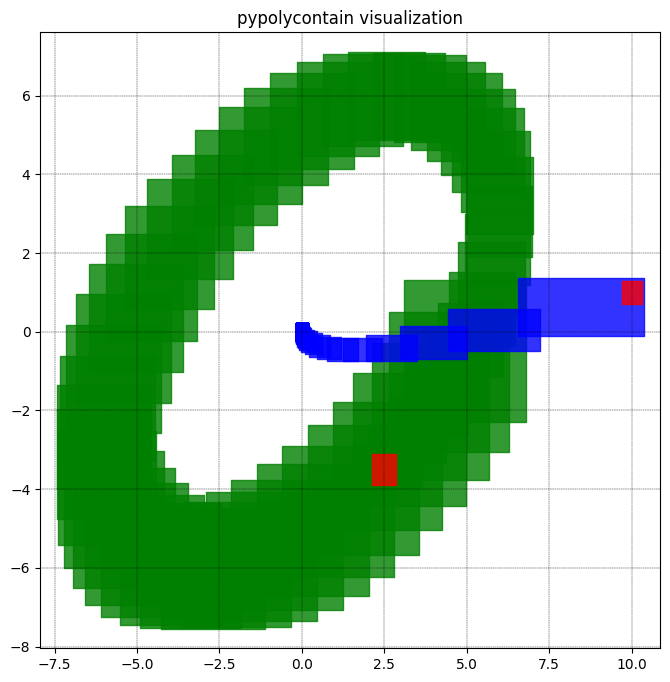

In [18]:
#PUT YOUR CODE HERE
from scipy.linalg import solve_continuous_are
A = np.array([[-1,1],[-1,1]])
B = np.array([[1,0],[0,1]])
Q = np.diag([120,55])
R = np.diag([5,5])
P = solve_continuous_are(A,B,Q,R)
K = -np.linalg.inv(R)@B.T@P

Ac = A + K

mu = 0.1
c0 = np.array([10,1])
g0 = np.array([[0.3,0],[0,0.3]])

zts_rob = get_zonotopes(Ac, mu, c0, g0, sim_duration, r, color="b", simplify=True)

fig, ax = plt.subplots()
try:
    pp.visualize(np.append(zts_obj,zts_rob), fig=fig, ax=ax)
except:
    pass
plt.show()


### VISUALIZATION

Here's an animation function which should give you some indication of what is actually going on:

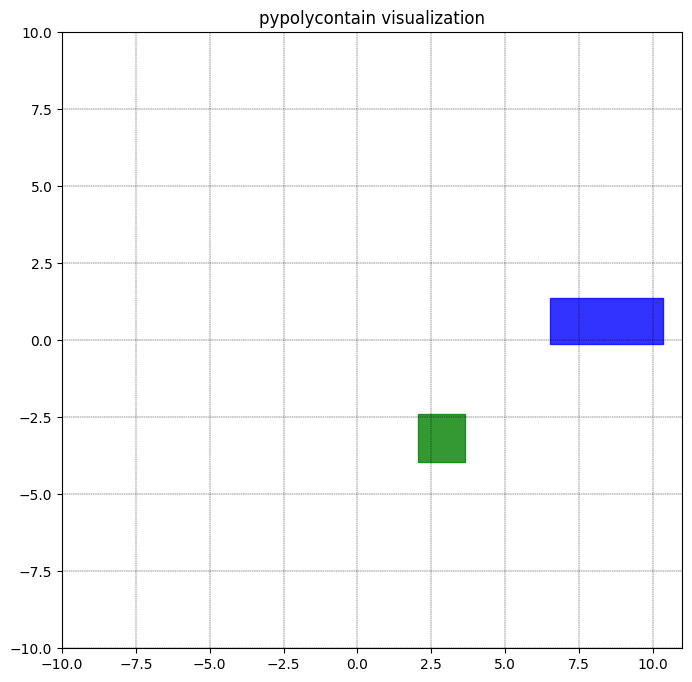

In [19]:
## ANIMATION FUNCTION
def animation_func(i, data):
    zts_obj = data[0]
    zts_rob = data[1]
    try:
        pp.visualize([zts_obj[i]], fig=fig, ax=ax)
    except:
        pass
    try:
        pp.visualize([zts_rob[i]], fig=fig, ax=ax)
    except:
        pass
    ax.set_xlim([-10, 11])
    ax.set_ylim([-10, 10])


fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(
    fig,
    animation_func,
    fargs=((zts_obj, zts_rob),),
    frames=len(zts_obj),
    interval=50,
    blit=False,
)
# HTML(animation.to_html5_video())

# Collisions!

Given the fact that we limit ourselves to zonotopes with two generators, we can do a simple collision check on two rectangles. This involves checking overlap with 4 conditions given the center and height and width (or edge points) of the rectangles. 

Implement this very simple rectangle collision checker in a function:

In [20]:
def simple_collision_check(zts_obj, zts_rob):
    collision = False
    
    for i in range(len(zts_obj)):
        center_obj = zts_obj[i].x
        center_rob = zts_rob[i].x

        gen_obj = zts_obj[i].G
        gen_rob = zts_rob[i].G

        obj_w = np.array([center_obj[0]-gen_obj[0,0], center_obj[0]+gen_obj[0,0]]) #left obj, right obj
        obj_h = np.array([center_obj[1]-gen_obj[1,1], center_obj[1]+gen_obj[1,1]]) #top obj, bottom obj

        rob_w = np.array([center_rob[0]-gen_rob[0,0], center_rob[0]+gen_rob[0,0]]) #left rob, right rob
        rob_h = np.array([center_rob[1]-gen_rob[1,1], center_rob[1]+gen_rob[1,1]]) #top rob, bottom rob

        # if left rob is inside left and right of object, or right rob is inside left and right of object, or top rob is inside top and bottom of object, or bottom rob is inside top and bottom of object
        collision = (obj_w[0] >= rob_w[0] >= obj_w[1]) or (obj_w[0] >=rob_w[1] >= obj_w[1]) or (obj_h[0] >=rob_h[0] >= obj_h[1]) or (obj_h[0] >=rob_h[1] >= obj_h[1])
        if collision:
            print("Collision occured at time step: ", i+1)
            break
    
                         
    # for ...:
    #   collision = smth and smth else and smth else and smth else
    # print whether a collision occured or not


simple_collision_check(zts_obj, zts_rob)

However, this does not generalize to zonotopes with many more generators. A given is that regardless of how many generators a zonotope has, the shape is always convex! As such, we can check the collision via intersection of two convex polytopes which we will construct using shapely.geometry.Polygon.

We could of course check intersection by methods that explicitly rely on zonotopes (e.g. [this](https://graphics.stanford.edu/~anguyen/papers/zonotope.pdf)). You're free to implement these methods, yet using the shapely library suffices for now. We are going to use it later on as well.

Implement this more general collision checker in a function:

In [21]:
def polygon_collision_check(zts_obj, zts_rob):
    collision = False

    for i in range(len(zts_obj)):
        obj_vertices = pp.conversions.zonotope_to_V(zts_obj[i])
        rob_vertices = pp.conversions.zonotope_to_V(zts_rob[i])
        obj_polygon = Polygon(obj_vertices)
        rob_polygon = Polygon(rob_vertices)
        # fig, ax = plt.subplots()
        # try:
        #     pp.visualize(np.append(zts_obj[i], zts_rob[i]), fig=fig, ax=ax)
        # except:
        #     pass
        # plt.show()
        if obj_polygon.intersects(rob_polygon):
            collision = True
            print("Collision occured at time step: ", i + 1)
            break


polygon_collision_check(zts_obj, zts_rob)

Seems like we're not in collision then! However, we are currently having a severe oversight (you might have already noticed it yourself!). Due to the time-discretization, we are checking collisions at distinct instances in time. Whatever happens inbetween these instances, we do not know or consider!

A straightforward, yet conservative, solution to this is to check collision for the convex hulls of the robot and the object of two discrete instances of time. Although we could use an off-the-shelf algorithm to find the convex hull of a set of points (originating from the points of the vertices of the two zonotopes), where's the fun in that? 

Instead, in this part, we will create our own convex-hull algorithm that returns a convex `shapely` polygon of a given set of points! A good starting point, and quite a straight-forward algorithm is the `Graham's scan algorithm`. Feel free, however, to use any algorithm you want! As long as it returns a convex `shapely` polygon!

In [ ]:
def get_orientation(p, q, r):
    """
    input : p,q,r = 2D points
    output : 0 if colinear, 1 if clockwise, 1 if counter-clockwise
    """
    val = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])
    if val == 0:
        return 0
    return 1 if val > 0 else -1


def graham_scan(pts):  # (or whatever algorithm you want!)
    # PUT YOUR CODE HERE

    # sort the points based on x and y, making the first point the one with the lowest x and y
    pts_sorted = pts[np.lexsort((pts[:, 0], pts[:, 1]))]

    # find the angle of the other points w.r.t. the first point and sort them in ascending order of angle
    p0 = pts_sorted[0]
    pts_sorted = pts_sorted[1:]
    angles = np.arctan2(pts_sorted[:, 1] - p0[1], pts_sorted[:, 0] - p0[0])
    pts_sorted = pts_sorted[np.argsort(angles)]
    pts_of_polygon = np.array([p0, pts_sorted[0]])

    for i in range(1, len(pts_sorted)):
        # compare the point with the last two points of the polygon, if the orientation is not counter-clockwise, remove the last point
        orientation = get_orientation(
            pts_of_polygon[-2], pts_of_polygon[-1], pts_sorted[i]
        )

        # pop the points if it is rotating clockwise
        if orientation == -1:
            pts_of_polygon = np.delete(pts_of_polygon, -1, 0)
        # append the new point
        pts_of_polygon = np.vstack((pts_of_polygon, pts_sorted[i]))

    # pts_of_polygon structure : [[x1,y1],[x2,y2],...,[xn,yn]]
    return Polygon([[v[0], v[1]] for v in pts_of_polygon]), pts_sorted


# where pts_sorted is all the points sorted before applying the left-turn,
# right-turn check. This might help you with debugging purposes and allows you
# to directly use the example below:

pts = np.array(
    [
        [9.7, -0.3],
        [10.3, -0.3],
        [10.3, 0.3],
        [9.7, 0.3],
        [7.3019237, -0.67042288],
        [8.17008638, -0.67042288],
        [8.17008638, -0.17500955],
        [7.3019237, -0.17500955],
        [4.04093198, -1.63931786],
        [4.7517695, -1.63931786],
        # [ 3.7517695 , -1.63931786], #ex, remove
        [4.7517695, -1.10690099],
        [4.04093198, -1.10690099],
        [4.5013919, -0.86892737],
        [5.28560014, -0.86892737],
        [5.28560014, -0.33356628],
        [4.5013919, -0.33356628],
    ]
)

pts_test = np.array(
    [
        [2.03786979, -3.95298836],
        [3.65156389, -3.95298836],
        [3.65156389, -2.38181335],
        [2.03786979, -2.38181335],
        [2.63791521, -3.32281067],
        [4.37663978, -3.32281067],
        [4.37663978, -1.63382442],
        [2.63791521, -1.63382442],
        [3.19066319, -2.6376564],
        [5.03080886, -2.6376564],
        [5.03080886, -0.85728641],
        [3.19066319, -0.85728641],
        [3.68679922, -1.90907128],
        [5.60304755, -1.90907128],
        [5.60304755, -0.06528497],
        [3.68679922, -0.06528497],
        [4.11460359, -1.14933291],
        [6.08707205, -1.14933291],
        [6.08707205, 0.72883364],
        [4.11460359, 0.72883364],
        [4.46642894, -0.37124385],
        [6.47516425, -0.37124385],
        [6.47516425, 1.51168752],
        [4.46642894, 1.51168752],
        [4.74014405, 0.4120841],
        [6.7569868, 0.4120841],
        [6.7569868, 2.27008458],
        [4.74014405, 2.27008458],
        [4.93113648, 1.18745085],
        [6.92779065, 1.18745085],
        [6.92779065, 2.99124484],
        [4.93113648, 2.99124484],
        [5.03618774, 1.89115972],
        [6.98469752, 1.89115972],
        [6.98469752, 3.71364661],
        [5.03618774, 3.71364661],
        [4.9824528, 2.49378407],
        [6.99782324, 2.49378407],
        [6.99782324, 4.44268472],
        [4.9824528, 4.44268472],
        [4.81144639, 3.04970986],
        [6.92633743, 3.04970986],
        [6.92633743, 5.10153299],
        [4.81144639, 5.10153299],
        [4.55651574, 3.54956903],
        [6.74097913, 3.54956903],
        [6.74097913, 5.67908898],
        [4.55651574, 5.67908898],
        [4.21889357, 3.98201764],
        [6.44793508, 3.98201764],
        [6.44793508, 6.1685408],
        [4.21889357, 6.1685408],
        [3.80289017, 4.33845351],
        [6.05352251, 4.33845351],
        [6.05352251, 6.56295544],
        [3.80289017, 6.56295544],
        [3.319958, 4.61710576],
        [5.55994551, 4.61710576],
        [5.55994551, 6.85145096],
        [3.319958, 6.85145096],
        [2.7782351, 4.81327876],
        [4.97552147, 4.81327876],
        [4.97552147, 7.02916585],
        [2.7782351, 7.02916585],
        [2.14531907, 4.92366674],
        [4.35162982, 4.92366674],
        [4.35162982, 7.09310537],
        [2.14531907, 7.09310537],
        [1.40171186, 4.88154516],
        [3.72894742, 4.88154516],
        [3.72894742, 7.10705642],
        [1.40171186, 7.10705642],
        [0.62797923, 4.71579435],
        [3.04993225, 4.71579435],
        [3.04993225, 7.04261339],
        [0.62797923, 7.04261339],
        [-0.16284044, 4.46590126],
        [2.32602661, 4.46590126],
        [2.32602661, 6.86416838],
        [-0.16284044, 6.86416838],
        [-0.95742083, 4.13347381],
        [1.56942921, 4.13347381],
        [1.56942921, 6.57733152],
        [-0.95742083, 6.57733152],
        [-1.74237224, 3.72181548],
        [0.7928897, 3.72181548],
        [0.7928897, 6.18923474],
        [-1.74237224, 6.18923474],
        [-2.50446722, 3.24276468],
        [0.00949377, 3.24276468],
        [0.00949377, 5.70151651],
        [-2.50446722, 5.70151651],
        [-3.2308635, 2.70439404],
        [-0.76755736, 2.70439404],
        [-0.76755736, 5.12239551],
        [-3.2308635, 5.12239551],
        [-3.94580323, 2.08099074],
        [-1.48868651, 2.08099074],
        [-1.48868651, 4.49641572],
        [-3.94580323, 4.49641572],
        [-4.6826267, 1.33964527],
        [-2.09635381, 1.33964527],
        [-2.09635381, 3.87754038],
        [-4.6826267, 3.87754038],
        [-5.35070759, 0.56738904],
        [-2.65852916, 0.56738904],
        [-2.65852916, 3.20165951],
        [-5.35070759, 3.20165951],
        [-5.9387879, -0.22276444],
        [-3.16573919, -0.22276444],
        [-3.16573919, 2.4801626],
        [-5.9387879, 2.4801626],
        [-6.4390008, -1.01750007],
        [-3.60739366, -1.01750007],
        [-3.60739366, 1.72520777],
        [-6.4390008, 1.72520777],
        [-6.84598482, -1.80342553],
        [-3.97298237, -1.80342553],
        [-3.97298237, 0.949517],
        [-6.84598482, 0.949517],
        [-7.14777091, -2.56729698],
        [-4.26145554, -2.56729698],
        [-4.26145554, 0.16616167],
        [-7.14777091, 0.16616167],
        [-7.3392736, -3.29624219],
        [-4.46795201, -3.29624219],
        [-4.46795201, -0.61165769],
        [-7.3392736, -0.61165769],
        [-7.4172658, -4.00738272],
        [-4.58899206, -4.00738272],
        [-4.58899206, -1.3414286],
        [-7.4172658, -1.3414286],
        [-7.43286481, -4.74802883],
        [-4.57010447, -4.74802883],
        [-4.57010447, -1.9515596],
        [-7.43286481, -1.9515596],
        [-7.38251915, -5.42066257],
        [-4.41489611, -5.42066257],
        [-4.41489611, -2.51680631],
        [-7.38251915, -2.51680631],
        [-7.21793427, -6.01394921],
        [-4.17512539, -6.01394921],
        [-4.17512539, -3.02764359],
        [-7.21793427, -3.02764359],
        [-6.94356603, -6.5194952],
        [-3.85315035, -6.5194952],
        [-3.85315035, -3.47385908],
        [-6.94356603, -3.47385908],
        [-6.56817431, -6.93272536],
        [-3.45026028, -6.93272536],
        [-3.45026028, -3.84398956],
        [-6.56817431, -3.84398956],
        [-6.09226612, -7.24112822],
        [-2.9790632, -7.24112822],
        [-2.9790632, -4.13734587],
        [-6.09226612, -4.13734587],
        [-5.52386113, -7.43950678],
        [-2.44749938, -7.43950678],
        [-2.44749938, -4.34898458],
        [-5.52386113, -4.34898458],
        [-4.89382442, -7.52451813],
        [-1.84323964, -7.52451813],
        [-1.84323964, -4.47533931],
        [-4.89382442, -4.47533931],
        [-4.28268077, -7.54093965],
        [-1.10655865, -7.54093965],
        [-1.10655865, -4.46807088],
        [-4.28268077, -4.46807088],
        [-3.61319701, -7.4976477],
        [-0.33740218, -7.4976477],
        [-0.33740218, -4.31814869],
        [-3.61319701, -4.31814869],
        [-2.8966548, -7.34000877],
        [0.45126849, -7.34000877],
        [0.45126849, -4.08346214],
        [-2.8966548, -4.08346214],
        [-2.14512877, -7.07190116],
        [1.24616326, -7.07190116],
        [1.24616326, -3.76674414],
        [-2.14512877, -3.76674414],
        [-1.37128312, -6.70289791],
        [2.03388712, -6.70289791],
        [2.03388712, -3.36827669],
        [-1.37128312, -3.36827669],
        [-0.58815814, -6.23294025],
        [2.80116592, -6.23294025],
        [2.80116592, -2.90105145],
        [-0.58815814, -2.90105145],
        [0.19104951, -5.66994756],
        [3.53507003, -5.66994756],
        [3.53507003, -2.37294177],
        [0.19104951, -2.37294177],
        [0.93796443, -5.03794229],
        [4.23847698, -5.03794229],
        [4.23847698, -1.77831164],
        [0.93796443, -1.77831164],
        [1.5529065, -4.43072282],
        [4.9866271, -4.43072282],
        [4.9866271, -1.04403311],
        [1.5529065, -1.04403311],
        [2.12418808, -3.76450145],
        [5.66823818, -3.76450145],
        [5.66823818, -0.27649981],
        [2.12418808, -0.27649981],
        [2.64218237, -3.05050488],
        [6.27182417, -3.05050488],
        [6.27182417, 0.51135435],
        [2.64218237, 0.51135435],
        [3.09743465, -2.30076487],
        [6.78793973, -2.30076487],
        [6.78793973, 1.306253],
        [3.09743465, 1.306253],
        [2.13220036, -3.88575152],
        [2.86779964, -3.88575152],
        [2.86779964, -3.11424848],
        [2.13220036, -3.11424848],
    ]
)


# pts_sorted = graham_scan(pts)
poly, pts_sorted = graham_scan(pts)
plt.scatter(pts_sorted[:, 0], pts_sorted[:, 1])
for i in range(0, len(pts_sorted)):
    plt.annotate(i, (pts_sorted[i, 0], pts_sorted[i, 1]))
plt.plot(*poly.exterior.xy)
plt.show()

# feel free to use whatever algorithm you want. You might not obtain a sorted
# sequence of points, so you might need to change the example a bit. pts_sorted
# is not used in the remainder of this tutorial! A requirement is that you
# code the algorithm yourself!!! Have a look at
# https://en.wikipedia.org/wiki/Convex_hull_algorithms
###

Implement this in a collision checker function:

an additional requirement: plot the convex hulls in a figure, until a collision is detected!

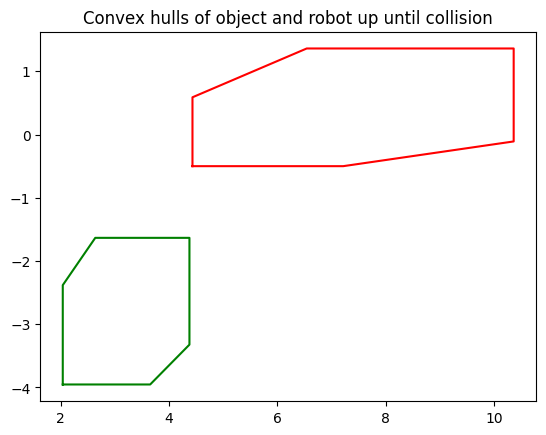

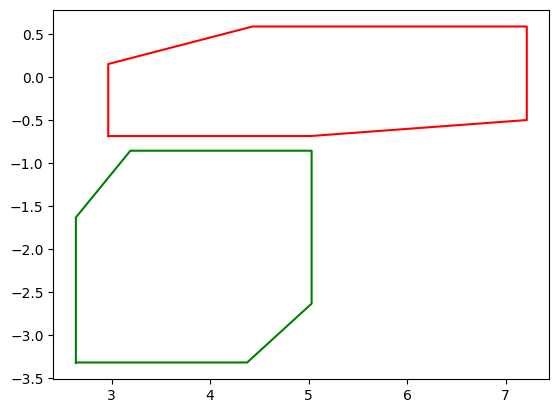

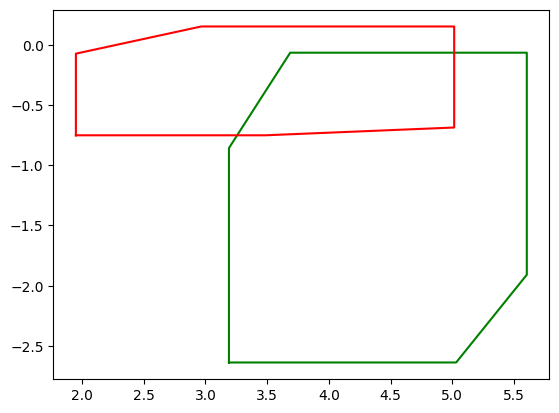

Collision occured at time step:  3


In [28]:
def convex_hull_collision_check(zts_obj,zts_rob):
  plt.figure()
  plt.title("Convex hulls of object and robot up until collision")
  collision = False
  for i in range(len(zts_obj)-1):
    pts_obj = np.vstack((pp.conversions.zonotope_to_V(zts_obj[i]), pp.conversions.zonotope_to_V(zts_obj[i+1])))
    pts_rob = np.vstack((pp.conversions.zonotope_to_V(zts_rob[i]), pp.conversions.zonotope_to_V(zts_rob[i+1])))
    ply_obj,_ = graham_scan(pts_obj)
    ply_rob,_ = graham_scan(pts_rob)


    x,y = ply_obj.exterior.coords.xy
    plt.plot(x,y,'g')
    x,y = ply_rob.exterior.coords.xy
    plt.plot(x,y,'r')
    plt.show()
    if ply_obj.intersects(ply_rob):
      collision = True
      print("Collision occured at time step: ", i+1)
      break

convex_hull_collision_check(zts_obj,zts_rob)


Do you get a different answer?

# (A level) Collision! What to do now?
What you have been doing so far is often referred to as $\textit{verification}$ process since you are using the knowledge of your system to analyze whether some desired specification (do not collide with an obstacle) holds or not.

In the next couple of steps, you're gonna look into the so called $\textit{synthesis}$ process in which you are given a desired system specification and you design a control strategy $u$ such that the specification holds. Specifically, you're gonna design different Control Barrier Functions (CBFs) to guarantee that the robot stays within an obstacle-free safeset. CBFs have been covered in the lectures but if you would like to refresh your knowledge you might want to have a look at $\href{https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8796030&casa_token=CtgTXVjMhTAAAAAA:93TomzH638Rg17rJl9LRW5WYljATBuiBor0OkfvSXwvZ-Y0rO-xkOhK15JBWIqrcIDgnqlEX}{this} $ publication.

# Simple yet provably safe controller
First, we will design a very conservative barrier function. In this case, we would like to obtain a halfspace constraint that contains all possible obstacle locations. If we can design a controller that stays within this obstacle-free halfspace, we are guaranteed to avoid collisions.


Such a halfspace can be defined as $\mathcal{H} = \left\{ x \in \mathbb{R}^n \mid a^T x \leq b\right\}$. Recall, that any polygon can also be written as an intersection of halfspaces. Convince yourself that the convex hull of all obstacle location from $t=0, \dots , T$ contains all possible locations the obstacle might be at. In the following, try to find this convex polygon and visualize it!

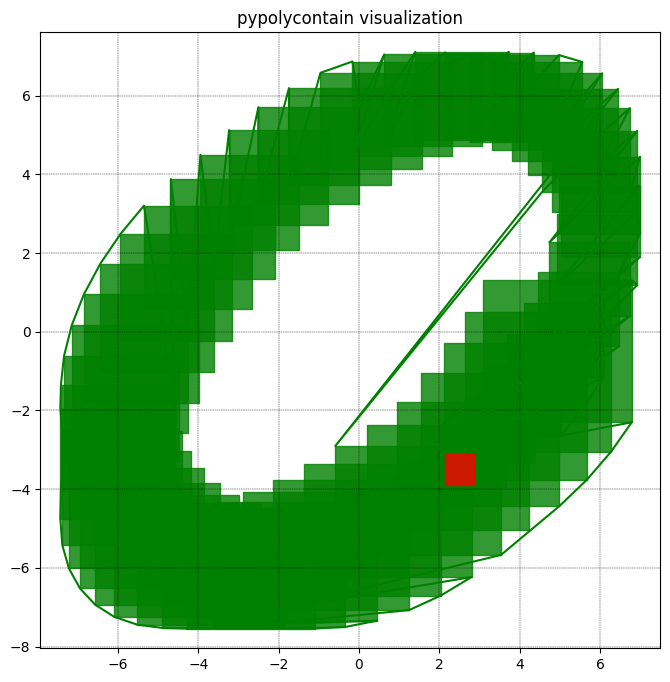

In [31]:
# trajectory of the obstacle in V-form
obj_trajectory = [pp.zonotope_to_V(zts_obj[i]).tolist()[j] for i in range(len(zts_obj)) for j in range(4)]
obj_trajectory = np.vstack(obj_trajectory)

# convex hull of obstacle trajectory
conv_hull_obj,_ = graham_scan(obj_trajectory)

# Visualization
x,y = conv_hull_obj.exterior.coords.xy

try:
    pp.visualize(zts_obj)
except:
    pass
plt.plot(x,y,'g')
plt.show()

Next, in order to define our barrier function, we need the convex hull of the obstacle trajectory in halfspace form (H-polytope). Unfortunatel, the function provided in `pypolycontain` does not work properly, so we have to do the conversion ourselves. Recall that each edge of the polytope between two consecutive vertices $V_i$ and $V_{i+1}$ can be described as a linear function of the form $a^T x - b = 0$.

Note, that the convex hull has many vertices, so we would like to create a list of tuples that contains all the halfspaces $halfspaces = [(a_0, b_0), \dots, (a_{N-1}, b_{N-1})]$ where $N$ is the number of vertices. Since it can be tideous to find the correct sign of the halfspaces, this function is provided in the following. Try to understand the code!

In [ ]:
vertices = np.array([[x[i], y[i]] for i in range(len(x))])


def construct_halfspaces(vertices_list):
    halfspaces = []
    

    for i in range(len(vertices_list) - 1):
        # vertex i
        p1 = vertices[i]
        # vertex i+1
        p2 = vertices[i + 1]

        # change in x and y
        dx = p2[0] - p1[0]
        dy = (p2[1] - p1[1]) * np.sign(dx)

        a = [dy / abs(dx), -1]
        b = a[0] * p1[0] + a[1] * p1[1]
        if dx < 0:
            a = [-a[0], -a[1]]
            b *= -1
        halfspaces.append((a, b))

    return halfspaces


halfspaces = construct_halfspaces(vertices.tolist())

# visualize all the halfspaces
try:
    pp.visualize(zts_obj)
except:
    pass
plt.plot(x, y, "g")
for ab in halfspaces:
    plt.plot(
        [-10, 10],
        [(ab[1] - ab[0][0] * (-10)) / ab[0][1], (ab[1] - ab[0][0] * (10)) / ab[0][1]],
        "r",
    )
plt.show()

NameError: name 'x' is not defined

Now, any of these halfspaces could be used as a candidate CBF since the intersection of all halfspaces $\mathcal{O} = \left\{x \in \mathbb{R}^n \mid \bigwedge_{i=0}^{N-1} a_i^T x \leq b_i \right\}$ represents the obstacle region and, thus, if any of the halfspace constraints is violated, i.e. $\bigvee_{i=0}^{N-1} a_i^T x \geq b_i$, then the robot is outside of the obstacle region $\mathcal{O}$.

The question that remains is: Which one is the most suitable halfspace constraint? It's a design choice! We would like to obtain a halfspace that contains the initial position of the robot $x_0$ and allows us to get as close as possible to the goal $g = [0, 0]$. Hint: use the distance between a point and a line!

In [ ]:
# for ...:
# ...
# a_min =
# b_min =

try:
    pp.visualize(zts_obj)
except:
    pass
plt.plot(x, y, "g")
plt.plot(
    [-10, 10],
    [(b_min - a_min[0] * (-10)) / a_min[1], (b_min - a_min[0] * (10)) / a_min[1]],
    "r",
)
plt.show()

Let's define our CBF! Remember, the safeset which we would like to render invariant (basically means if we are inside the set, we will remain in the set) is of the form

$\mathcal{C} = \left\{x \in \mathbb{R}^n \mid h\left(x, t\right) \geq 0 \right\}$

where our barrier function $h$ might depend explicitly on time. In our first scenario, however, we generate a constant CBF so there won't be any time dependencies.

In [ ]:
h_static = lambda x, t:


## Control Synthesis!
Now that we've defined our CBF, we need to synthesize control inputs $u$ which render $\mathcal{C}$ invariant. Have a look at the lectures (or the linked paper) again and convince yourself that 

$\dot{h}\left(x, t\right) \geq - \gamma h\left(x, t\right)$

ensures invariance. By applying the chain rule to the above constraint, we can obtain an expression

$\dot{h}(x, t) = \frac{\partial h }{\partial x} \dot{x} + \frac{\partial h}{\partial t} = \frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq -\gamma h(x, t)$

which is linear in the control input and, thus, this constraint can be included in convex optimization problems!

Basically, what we want to do now is to develop a safety filter that takes as input a reference control input $u_{ref}$, e.g. the LQR control input, and outputs a safe control input that satisfies the safety constraint. Additionally, this modified control input should be as close as possible to the reference input so that the robot follows its reference controller and the safety filter only intervenes if we're about to violate the safety specification. This can be formulated as an optimization problem

$$
\begin{aligned}
	\min_{u} \quad &(u - u_{ref})^T Q (u - u_{ref})\\
	\textrm{s.t.  } \quad  &\frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq - \gamma h(x, t)
    \end{aligned}.
$$

which is a quadratic program (QP) and, thus, can be solved efficiently. For the following simulations simply assume that the robot disturbance is zero, i.e. $d=0$.

In order to solve the optimization problem, we will make use of python convex optimization package `cvxopt`. Please have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example of how to formulate and solve a QP in python. Hint: formulate the optimization using the decision variable $\tilde{u} = u - u_{ref}$ which requires slight modification of the safety constraint.

In [ ]:
# Some imports for the CBF formulation
from scipy.integrate import odeint
from math import sin, cos, sqrt, atan2, pi
from cvxopt import matrix, solvers

Let's define the function of the safety filter!

In [ ]:
def safety_filter(x, h, t):
    gamma = 10
    #     # reference control input
    #     u_ref =

    #     # Barrier condition dhdx * (f(x) + g(x) u) >= -h(x)
    #     dhdx =

    #     dhdt =

    #     # set up QP:
    #     Q =
    #     p =
    #     G =

    #     t =

    #     solvers.options['show_progress'] = False
    #     sol = solvers.qp(Q, p, G, t)
    #     u_safe =

    return u_safe

Now we're gonna run a simple simulation which should show that the static halfspace constraint is always satisfied. To do so, we need to define the closed loop system and call a differential equation solver!

In [ ]:
def closed_loop_system(x, t):
    # controller
    return dx


# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)


x_sol = odeint(closed_loop_system, c0, t_sim)

fig, ax = plt.subplots()
try:
    pp.visualize(zts_obj, fig=fig, ax=ax)
except:
    pass
plt.plot(
    [-10, 10],
    [(b_min - a_min[0] * (-10)) / a_min[1], (b_min - a_min[0] * (10)) / a_min[1]],
    "r",
)
plt.plot(x, y, "g")
plt.plot(x_sol[:, 0], x_sol[:, 1], "b")
plt.show()

## Let's see an animated version!
It might take a while to visualize.

In [ ]:
## ANIMATION FUNCTION
def animation_func(i, data):
    current_t = i * (sim_duration / len(t_sim))
    zts_obj = data[0]
    robot_pos = data[1]
    pp.visualize(
        [zts_obj[min(len(zts_obj) - 1, int(np.floor(current_t / r)))]], fig=fig, ax=ax
    )
    plt.plot(robot_pos[0:i, 0], robot_pos[0:i, 1], "b")
    ax.set_xlim([-10, 11])
    ax.set_ylim([-10, 10])


fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(
    fig,
    animation_func,
    fargs=((zts_obj, x_sol),),
    frames=len(t_sim) - 1,
    interval=50,
    blit=False,
)
HTML(animation.to_html5_video())

## Safe? yes! Is it what we want? No..
From this simulation we can observe that the robot indeed stays safe at all time, i.e. it does not collide with the dynamic obstacle. However, it is also rather conservative since the robot stays in the safe halfspace although the obstacle is far away. How can we change that? The key is to consider a timevarying control barrier function that changes whenever the obstacle is moving. In this section we will look into more sophisticated CBFs that will change over time. In this way, we will not only ensure safety but also ensure that our robot reaches its destination!

One requirement of a valid CBF is that it's continuous in time and continuously differentiable with respect to $x$ and $t$. Since we only have the obstacle zonotopes at discrete time steps, we will use a simple linear time interpolation for the obstacle between time steps $t_k$ and $t_{k+1}$.

The following function takes the current time as well as the list of discrete zonotopes and returns a polytope in vertex form (V_polytope) at the current time.

In [ ]:
def cont_time_obstacle(t, zonotopes_obst):
  # Use simple linear interpolation
  t_last =
  t_next =
  obst_last = 
  obst_next = 
  # obstacle at current time t as V-representation
  obst_t = 

  return obst_t



Now we have a function to call that provides us with a polytope representation of the obstacle at any time. However, we still need to ensure that our robot is always outside of the polytope. There are different ways to ensure collision avoidance, e.g. taking the distance between a point and a polygon. However, this would be a nonsmooth measure in $x$ which is why we consider an overapproximating circle in the following.

Find the smallest circle that contains the entire polytope at time t!

In [ ]:
def bounding_radius(t, zonotopes_obst):
  # Use simple linear interpolation
  ind = int(np.floor(t / r))
  t0 = ind * r
  t1 = (ind+1) * r
  
  # Zonotope centers
  z_c0 = zonotopes_obst[min(ind, len(zts_obj)-1)].x
  z_c1 = zonotopes_obst[min(ind+1, len(zts_obj)-1)].x


  # center of zonotope at time t
  z_c = z_c0 + ((z_c1 - z_c0) / (t1 - t0)) * (t - t0)

  r_bound = 

  return z_c, r_bound

# TEST
print(bounding_radius(1, zts_obj))

Let's check if our bounding circle algorithm works properly!

In [ ]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()
try:
    pp.visualize(zts_obj, fig=fig, ax=ax)
except:
    pass
for i in range(len(zts_obj)):
    tnow = i * r
    center, radius = bounding_radius(tnow, zts_obj)
    ax.add_artist(Circle(center, radius, fill=False))
plt.show()

In the case of a CBF that explicitly depends on time, we need to to account for the known change of the obstacle over time. In this case, the explicit CBF time derivative $\frac{\partial h}{\partial t}$ is nonzero.

However, since the explicit time dependency is not exactly known in our case (as a result of discrete reachibility analysis and time interpolation), we approximate the time derivative of the barrier function using finite differences. To be specific, we will use a simple forward difference method

$\frac{\partial f}{\partial t} (t) \approx \frac{f\left(t + \delta t\right) - f\left(t\right)}{\delta t}$.

The CBF we consider is given as

$h(x, t) = \lVert x - c_{obs}(t) \rVert_2 - r_{obs}(t) \geq 0$

In the following, write a function that returns the value of the CBF $h(x, t)$, its gradient $\frac{\partial h}{\partial x}$ as well as its explicit time derivative $\frac{\partial h}{\partial t}$. Hint: you need to apply the chain rule for the gradient and the time derivative. Approximate explicit time derivatives $\frac{\partial c_{obs}}{\partial t}$ and $\frac{\partial r_{obs}}{\partial t}$ using finite differences.

In [ ]:
def cbf_dynamic(x, t):
    # Input: state defined as x = [x_robot, y_robot]
    # Output: Value of CBF h(x), gradient with respect to x dhdx(x), explicit time derivative dhdt

    return h_val, dhdx, dhdt


# Test
print(cbf_dynamic(c0, 0))

Now, we will define the safety filter similarly to the safety filter using the static CBF. Set up the QP and run the continuous time simulation. What can you observe? Try different parameter settings for $\gamma = [1, 10, 30]$. Also, plot the value of $h(x, t)$ over time for different values of $\gamma$. What is the trade-off when choosing large values of $\gamma$?

In [ ]:
def safety_filter(x, t):
    # PUT YOUR CODE HERE
    return u_safe


# closed loop dynamics including CBF controller
def closed_loop_system(x, t):
    # PUT YOUR CODE HERE
    return dx


# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)

x_sol = odeint(closed_loop_system, c0, t_sim)

fig = plt.figure()
ax = fig.add_subplot(121)
try:
    pp.visualize(zts_obj, fig=fig, ax=ax)
except:
    pass
plt.plot(x_sol[:, 0], x_sol[:, 1], "b")
ax.set_xlim([-10, 11])
ax.set_ylim([-10, 10])
ax2 = fig.add_subplot(122)
plt.plot(t_sim, [cbf_dynamic(x_sol[i], t_sim[i])[0] for i in range(len(t_sim))])
plt.show()

Lastly, we can see our robot in action! In this simulation section, you have been working on safe control synthesis in a reactive setting meaning that obstacle avoidance is guaranteed but it also could have been avoided at all if this problem would have been tackled at a higher level such as motion planning. Nonetheless, CBFs are an amazing tool for safety guarantees on a control level. There are many different topics that you could explore from here, e.g. robust CBFs, CBFs under uncertainties, CBFs for multi-agent systems, CBFs for safe reinforcement learning and many more!

In [ ]:
## ANIMATION FUNCTION
def animation_func(i, data):
    # visualize robot
    robot_pos = data
    plt.plot(
        [robot_pos[k][0] for k in range(i)], [robot_pos[k][1] for k in range(i)], "b"
    )

    current_t = i * (sim_duration / len(t_sim))

    # visualize obstacle set
    current_obs = cont_time_obstacle(current_t, zts_obj)
    conv_hull_obj = MultiPoint(current_obs).convex_hull
    x, y = conv_hull_obj.exterior.coords.xy
    poly_plot.set_xdata(x)
    poly_plot.set_ydata(y)

    c_obs, r_obs = bounding_radius(current_t, zts_obj)
    patch.center = c_obs
    patch.radius = r_obs

    ax.set_xlim([-10, 11])
    ax.set_ylim([-10, 10])


fig = plt.figure()
ax = fig.add_subplot(111)
conv_hull_obj = MultiPoint(cont_time_obstacle(0, zts_obj)).convex_hull
x, y = conv_hull_obj.exterior.coords.xy
(poly_plot,) = plt.plot(x, y, "g")
plt.plot([c0[0]], [c0[1]], marker="o", markersize=4, c="r")

# Visualize circle
c_obs, r_obs = bounding_radius(0, zts_obj)
patch = Circle(c_obs, r_obs, fill=False)
ax.add_artist(patch)


animation = FuncAnimation(
    fig, animation_func, fargs=((x_sol),), frames=len(x_sol), interval=50, blit=False
)
HTML(animation.to_html5_video())